In [1]:
!pip install tensorflow==2.9.1

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

import pathlib
import os


2023-03-20 10:19:31.335330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glob/development-tools/versions/oneapi/2023.0.1/oneapi/vpl/2023.0.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/tbb/2021.8.0/env/../lib/intel64/gcc4.8:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/rkcommon/1.10.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/ospray_studio/0.11.1/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/ospray/2.10.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/openvkl/1.3.1/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/oidn/1.4.3/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/mpi/2021.8.0//libfabric/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/mpi/2021.8.0//lib/release:/glob/development-tools/versions/oneapi/20

In [ ]:
!unzip /home/u188901/Intel_Hackathon/archive.zip

Archive:  /home/u188901/Intel_Hackathon/archive.zip
replace PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
FILE_PATH = "/home/u188901/Intel_Hackathon/PlantVillage"
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=FILE_PATH, shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size = BATCH_SIZE,)

Found 20638 files belonging to 15 classes.


In [5]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 256, 256, 3)
[10  6  2  8 14 12  5 12 14  7  7  3 13  0 12  5  1  3 10  8 12  6 12  6
  5 10 12  1  2 11  0 12  0  3  6  1  7  2 11  5  2  2 10  8 12  7  1 10
 12 12  1  0  9 12 14 10  0  6  7 11 12 12  7  0]


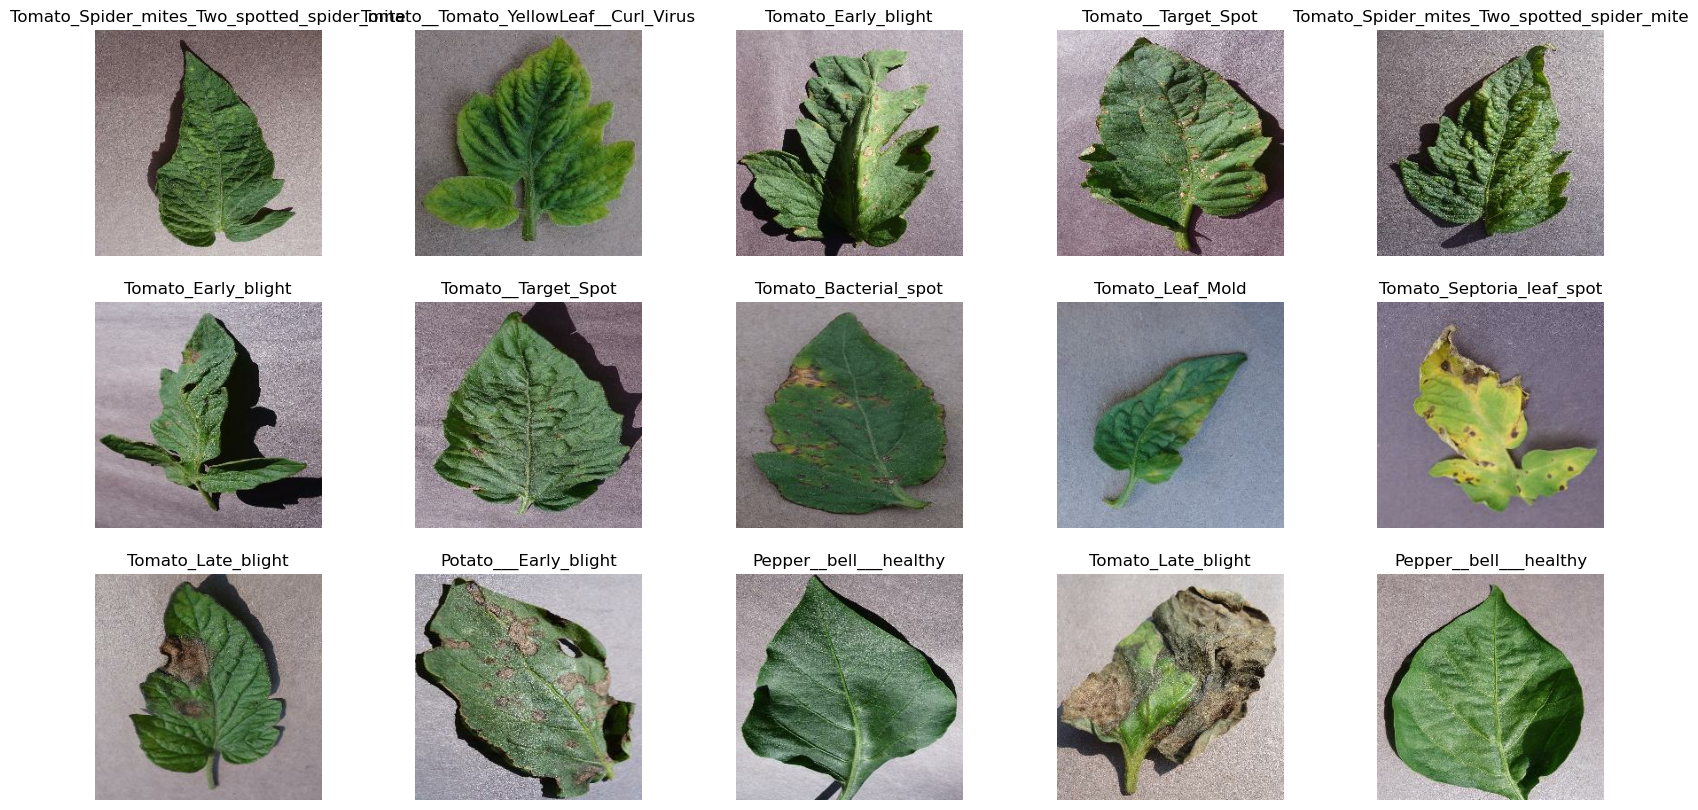

In [7]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)

  
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds ,test_ds, valid_ds

In [9]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)

In [10]:
print(len(train_ds))
print(len(test_ds))
print(len(valid_ds))

258
33
32


In [11]:
# performance improving by both using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [13]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)


model = models.Sequential([
    rescale_and_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                  

In [16]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [17]:
EPOCHS = 10

In [18]:
if 'history' not in locals():
    history = []
#model training
history.append(
    model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=valid_ds,
        verbose=1,
        epochs=EPOCHS
    )
)

Epoch 1/10


2023-03-20 10:23:08.677738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 142 of 1000
2023-03-20 10:23:15.994815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


258/258 [==============================] - ETA: 0s - loss: 2.2590 - accuracy: 0.2514

2023-03-20 10:31:02.466482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 17 of 1000
2023-03-20 10:31:03.412351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


258/258 [==============================] - 496s 2s/step - loss: 2.2590 - accuracy: 0.2514 - val_loss: 2.2201 - val_accuracy: 0.3047
Epoch 2/10
258/258 [==============================] - 463s 2s/step - loss: 1.6662 - accuracy: 0.4482 - val_loss: 1.4764 - val_accuracy: 0.4941
Epoch 3/10
258/258 [==============================] - 464s 2s/step - loss: 1.0959 - accuracy: 0.6302 - val_loss: 1.0052 - val_accuracy: 0.6709
Epoch 4/10
258/258 [==============================] - 462s 2s/step - loss: 0.7728 - accuracy: 0.7344 - val_loss: 0.8753 - val_accuracy: 0.7095
Epoch 5/10
258/258 [==============================] - 461s 2s/step - loss: 0.5903 - accuracy: 0.7961 - val_loss: 0.7904 - val_accuracy: 0.7544
Epoch 6/10
258/258 [==============================] - 461s 2s/step - loss: 0.5066 - accuracy: 0.8265 - val_loss: 0.7328 - val_accuracy: 0.7666
Epoch 7/10
258/258 [==============================] - 460s 2s/step - loss: 0.4352 - accuracy: 0.8484 - val_loss: 0.6471 - val_accuracy: 0.7988
Epoch 8/10

In [19]:
scores = model.evaluate(test_ds)
scores

2023-03-20 11:40:48.998867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-03-20 11:40:50.650195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


33/33 [==============================] - 22s 308ms/step - loss: 0.4620 - accuracy: 0.8470


[0.46195390820503235, 0.8469682335853577]

In [20]:
acc = []
val_acc = []
loss = []
val_loss = []

for h in history:
    acc.extend(h.history['accuracy'])
    val_acc.extend(h.history['val_accuracy'])
    loss.extend(h.history['loss'])
    val_loss.extend(h.history['val_loss'])

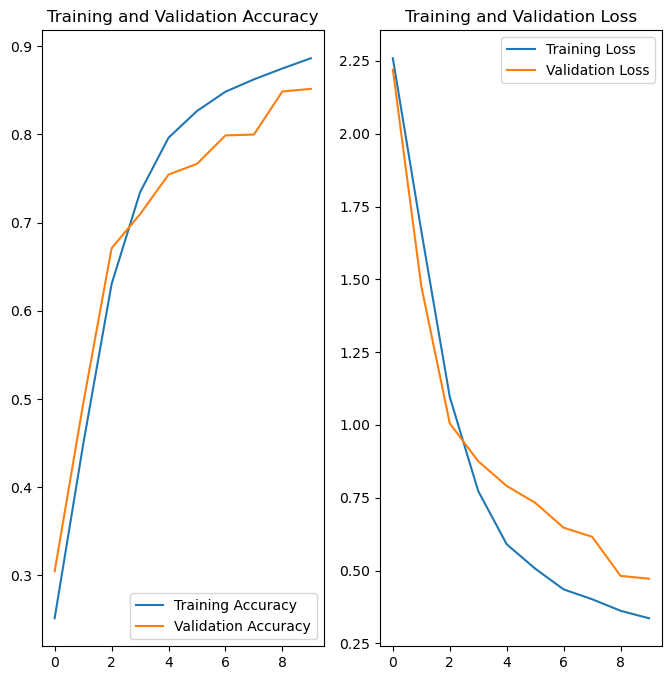

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Pepper__bell___healthy
2/2 [==============================] - 0s 148ms/step
predicted label: Pepper__bell___healthy


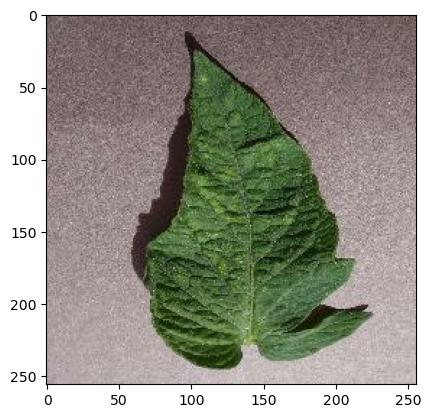

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
   
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    break

In [29]:
def predict_tomato_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
  

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


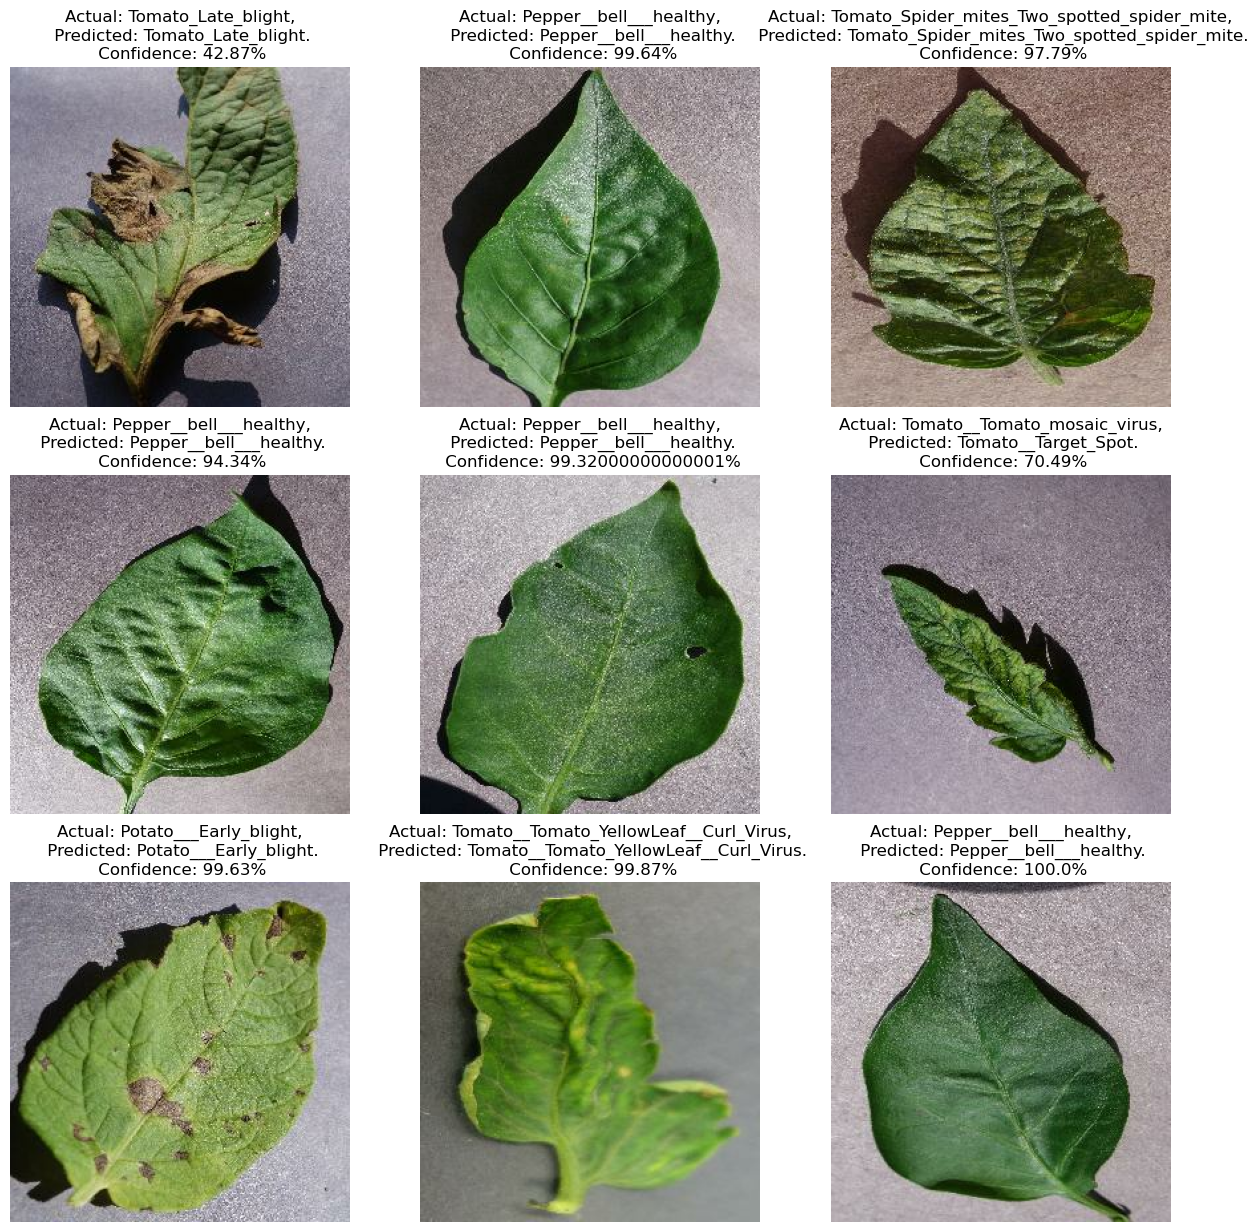

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_tomato_diseases(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
!mkdir models
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/tomato_{model_version}")

In [ ]:
model.save("tomato.h5")